In [1]:
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import os
import re
import sys
import scipy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
import numpy as np

from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive/')


%cd /content/gdrive/MyDrive/LonelinessR21
%ls


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive/
/content/gdrive/MyDrive/LonelinessR21
 annotation_Drew_sample_social_disconnection.xlsx
 annotation_Drew_sample_stigmatizing_labels.xlsx
 annotation_Selen_sample_social_disconnection.xlsx
 annotation_Selen_sample_stigmatizing_labels.xlsx
'Copy of loneliness_social_isolation_lexicon_evaluation.csv'
 gold_standard_loneliness_lexicon_df.csv
 gold_standard_social_isolation_1000.csv
 logs/
 loneliness_ehr_roberta.ipynb
 loneliness_gold_standard_expanded_lexicon_matches.xlsx
 loneliness_lexicon_dev.ipynb
 loneliness_lexicon.Rmd
 loneliness_lexicon_stem_and_similar_round1.csv
 loneliness_lexicon_stem_and_similar_round2.csv
 loneliness_matches_expanded.xlsx
 loneliness_matches.xlsx
 loneliness_regex_matching_and_sample.ipynb
 loneliness_roberta_ehr_performance.gsheet
 loneliness_social_isolation_lexicon_evaluation.csv
'loneliness_social_isolation_lexicon_evaluation KL.csv'
'Matched Terms from Social Disconnection Lexicon.png'
 new_loneliness_phrases.csv
 predictions

# Read in Lexicon

In [2]:
gold_standard_lexicon = pd.read_csv("gold_standard_loneliness_lexicon_df.csv")

In [3]:
gold_standard_lexicon

,word_id,expanded_word,gold_standard_label
0,0,feels isolated,1
1,1,feel isolated,1
2,2,isolation and loneliness,1
3,3,lack of social support,1
4,4,lack of social supports,1
...,...,...,...
77,81,solitude,1
78,82,individualistic,0
79,83,unaccompanied lifestyle,1
80,84,withdrawn behavior,1


In [4]:
# Subset the DataFrame
subset_df = gold_standard_lexicon[gold_standard_lexicon['gold_standard_label'] == 1][['expanded_word']]

# Convert the expanded_word column to a list
expanded_words = subset_df['expanded_word'].tolist()

phrases = expanded_words

# List of phrases

# Join phrases with '|' and create a regex pattern
pattern = '|'.join([re.escape(phrase) for phrase in phrases])
regex = re.compile(pattern, re.IGNORECASE)
regex

re.compile(r'feels\ isolated|feel\ isolated|isolation\ and\ loneliness|lack\ of\ social\ support|lack\ of\ social\ supports|lack\ in\ social\ support|loss\ of\ social\ network|no\ social\ support|limited\ social\ network|limited\ social\ support|limited\ social\ connection|loneliness|lonely|social\ isolation|social\ withdraw|socially\ withdrawn|socially\ isolated|socially\ isolating|friendlessness|no\ friends|no\ family\ support|no\ friends\ or\ family|no\ family\ or\ friends|loner|lives\ alone|loneliness\-a|lonelinesstype|solitary|alone|secluded|rejected|unaccompanied|abandoned|unconnected|unattended|isolated\ lifestyle|deserted|disconnected|uninvolved|withdrawn|alone\ in\ the\ world|isolated\ living|unsociable|estranged|shunned|lack\ of\ companionship|hermit|isolated\ existence|isolated\ behavior|socially\ excluded|hermitic|lack\ of\ interaction|rejected\ by\ society|social\ detachment|detached\ from\ others|excluded|reclusive|lack\ of\ belonging|separation\ from\ others|apart|solitu

In [6]:
import re

# Subset the DataFrame
subset_df = gold_standard_lexicon[gold_standard_lexicon['gold_standard_label'] == 1][['expanded_word']]

# Convert the expanded_word column to a list
expanded_words = subset_df['expanded_word'].tolist()

# Create a regex pattern using '|', no need to escape special characters here
pattern = '|'.join([phrase for phrase in expanded_words])

# Split the pattern into individual phrases (by '|')
clean_phrases = pattern.split('|')

# Remove any duplicates (optional) and strip leading/trailing spaces
clean_phrases = list(set([phrase.strip() for phrase in clean_phrases]))

# Join the cleaned phrases into a comma-separated string
comma_separated_phrases = ', '.join(clean_phrases)

# Count the number of phrases
phrase_count = len(clean_phrases)

# Print the results
print("Cleaned phrases:", comma_separated_phrases)
print("Number of phrases:", phrase_count)



Cleaned phrases: limited social connection, social detachment, no family support, unaccompanied, rejected by society, unaccompanied lifestyle, lack of interaction, isolation and loneliness, unsociable, separation from others, no friends or family, feels isolated, isolated behavior, rejected, secluded, uninvolved, loner, lack of social support, lack in social support, socially withdrawn, detached from others, limited social network, solitude, socially isolating, friendlessness, lives alone, isolated lifestyle, socially excluded, lonelinesstype, hermit, alone, loss of social network, isolated existence, social withdraw, alone in the world, withdrawn behavior, solitary, no family or friends, disconnected, loneliness, unconnected, excluded, isolated living, reclusive, lonely, no social support, loneliness-a, deserted, socially isolated, shunned, unattended, hermitic, social isolation, withdrawn, estranged, feel isolated, abandoned, no friends, lack of companionship, apart, lack of social s

In [ ]:
# Read in tokenized data frame
full_dataframe = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/mimic_iii_sentence_tokenized.csv")

small_dataframe = full_dataframe.head(100000)


<ipython-input-5-ddb851d86516>:2: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dataframe = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/mimic_iii_sentence_tokenized.csv")


In [ ]:

def identify_matching_strings(full_dataframe, phrases):
    matching_dataframes = []

    for phrase in phrases:
        term = r"\b" + re.escape(phrase) + r"\b"  # Adding word boundaries
        matches = full_dataframe.loc[full_dataframe['Sentence'].str.contains(term, flags=re.IGNORECASE, na=False)].copy()
        matches['regex'] = pattern
        matches['matched_term'] = phrase  # Add the matched term as a new column
        matching_dataframes.append(matches)

    first_dataframe = pd.concat(matching_dataframes, ignore_index=True)
    return first_dataframe

# Replace with full dataframe
quoted_dataframe = identify_matching_strings(full_dataframe, phrases)


# adding annotator variables
quoted_dataframe
quoted_dataframe["chronic_social_disconnection_label"] = ""
quoted_dataframe["lives_alone_label"] = ""
quoted_dataframe["acute_social_disconnection_label"] = ""

quoted_dataframe["annotator_comments"] = ""
quoted_dataframe["manuscript_example"] = ""

# removing duplicate sentences
quoted_dataframe2 = quoted_dataframe.drop_duplicates(subset=['Sentence'])
print(f"Sentences of loneliness matches: {quoted_dataframe2.shape[0]}")  # Print the size after filter
quoted_dataframe2.head()

unique_subject_ids_count = quoted_dataframe2['SUBJECT_ID'].nunique()

print(f"Number of unique patients: {unique_subject_ids_count}")

# writing to excel file
quoted_dataframe2.to_excel("loneliness_gold_standard_expanded_lexicon_matches.xlsx", index = False)



Sentences of loneliness matches: 12575
Number of unique patients: 5234


# Save loneliness stem word list match dataframe

In [ ]:
quoted_dataframe2 = pd.read_excel("loneliness_gold_standard_expanded_lexicon_matches.xlsx")

Explore the Data


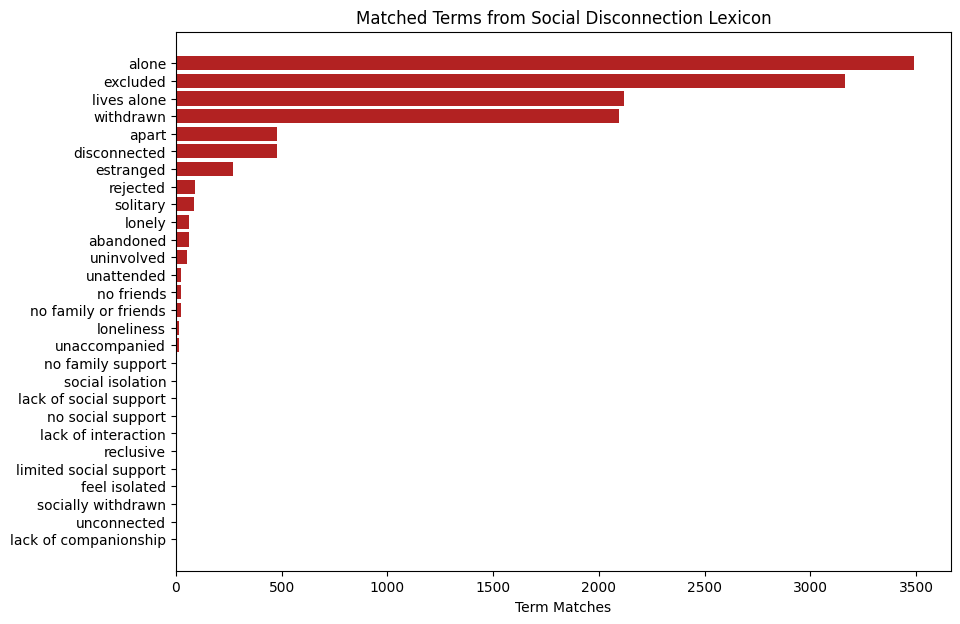

In [ ]:
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string
import re

# Function to create count horizontal bar chat
def plot_most_common(n_most_common, title):
    items, counts = zip(*n_most_common)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(items)), counts, color='firebrick')
    plt.yticks(range(len(items)), items)
    plt.xlabel("Term Matches")  # Adding x-axis label
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    plt.show()

# Get the frequency of each matched term
matched_term_freq = Counter(quoted_dataframe2['matched_term'])

# Get top 20 most common matched terms
top20_matched_terms = matched_term_freq.most_common(50)

# Plot top 20 most common matched terms
plot_most_common(top20_matched_terms, 'Matched Terms from Social Disconnection Lexicon')



In [ ]:
# Create the annotation samples
quoted_dataframe2 = pd.read_excel("loneliness_gold_standard_expanded_lexicon_matches.xlsx")
np.random.seed(24)
columns_to_keep = ['SUBJECT_ID','Sentence ID', 'TEXT', 'Sentence', 'matched_term', 'chronic_social_disconnection_label', 'lives_alone_label', 'acute_social_disconnection_label', 'annotator_comments','manuscript_example']
quoted_dataframe2 = quoted_dataframe2[columns_to_keep]

reliability_df = pd.read_excel("reliability_sample_social_disconnection.xlsx")

filtered_df = quoted_dataframe2[~quoted_dataframe2['Sentence ID'].isin(reliability_df['Sentence ID'])]


# List of tuples (sample size, dataframe name)
sample_params = [(450, 'annotation_Selen'), (450, 'annotation_Drew')]

# Dictionary to hold the dataframes
dfs = {}

for size, name in sample_params:
    # Ensure we don't sample more than one row per SUBJECT_ID
    grouped = filtered_df.groupby('SUBJECT_ID')

    # Sample one row per SUBJECT_ID within the group
    sample_df = grouped.apply(lambda x: x.sample(1)).reset_index(drop=True)

    # If the number of rows sampled exceeds the desired size, randomly select 'size' number of rows
    if len(sample_df) > size:
        sample_df = sample_df.sample(n=size, replace=False)

    # Add the sample to the dictionary
    dfs[name] = sample_df

    # Remove the sampled rows from the original dataframe
    filtered_df = quoted_dataframe2.drop(sample_df.index)


annotation_Selen_df = dfs['annotation_Selen']
annotation_Selen_df
annotation_Selen_df.to_excel("annotation_Selen_sample_social_disconnection.xlsx", index = False)

annotation_Drew_df = dfs['annotation_Drew']
annotation_Drew_df
annotation_Drew_df.to_excel("annotation_Drew_sample_social_disconnection.xlsx", index = False)


unique_subjects_drew = dfs['annotation_Drew']['SUBJECT_ID'].nunique()
print(f"Unique SUBJECT_IDs in annotation_Drew_df: {unique_subjects_drew}")

# Count unique values of SUBJECT_ID in annotation_Selen_df
unique_subjects_selen = dfs['annotation_Selen']['SUBJECT_ID'].nunique()
print(f"Unique SUBJECT_IDs in annotation_Selen_df: {unique_subjects_selen}")


Unique SUBJECT_IDs in annotation_Drew_df: 450
Unique SUBJECT_IDs in annotation_Selen_df: 450
